## Read Data

In [1]:
import pandas as pd
 
#this assumes one json item per line in json file
df=pd.read_json("../data/news_category_dataset.json", lines=True)

In [2]:
df.dtypes

authors                      object
category                     object
date                 datetime64[ns]
headline                     object
link                         object
short_description            object
dtype: object

In [33]:
#number of rows (datapoints)
len(df)

124989

In [36]:
df.sample(100)

,authors,category,date,headline,link,short_description,tokenized_url,text_desc,text_desc_headline,text_desc_headline_url
33414,"Rashidul Bari, ContributorA Servant of Education",RELIGION,2017-02-25,Tears For Zakir Khan,https://www.huffingtonpost.com/entry/tears-for...,I reached out to Khan when I was poor. However...,tears for zakir khan us 58b121bae4b02f3f81e447ce,I reached out to Khan when I was poor. However...,I reached out to Khan when I was poor. However...,I reached out to Khan when I was poor. However...
5736,Princess-India Alexander,BLACK VOICES,2018-02-13,#InWakanda Hashtag Brings The Blackest Of Nati...,https://www.huffingtonpost.com/entry/inwakanda...,""" #InWakanda ashiness does not exist! There is...",inwakanda hashtag black twitter us 5a821662e4b...,""" #InWakanda ashiness does not exist! There is...",""" #InWakanda ashiness does not exist! There is...",""" #InWakanda ashiness does not exist! There is..."
14177,Sara Boboltz,ENTERTAINMENT,2017-10-13,"The Ultimate Livingston, Montana, Road Trip Pl...",https://www.huffingtonpost.com/entry/the-ultim...,"Big Sky Country likes a blend of rock and pop,...",the ultimate livingston montana road trip play...,"Big Sky Country likes a blend of rock and pop,...","Big Sky Country likes a blend of rock and pop,...","Big Sky Country likes a blend of rock and pop,..."
67296,Nina Golgowski,WEIRD NEWS,2016-02-07,Holy Crab! Fearless Australian Poses With Mass...,https://www.huffingtonpost.com/entry/coconut-c...,"""To get nipped by one you have to be pretty sl...",coconut crab christmas island us 56b75b07e4b08...,"""To get nipped by one you have to be pretty sl...","""To get nipped by one you have to be pretty sl...","""To get nipped by one you have to be pretty sl..."
66785,Samantha Lachman,POLITICS,2016-02-12,Hillary Clinton Hits Scott Walker On His Home ...,https://www.huffingtonpost.com/entry/hillary-c...,The audience at the debate loved her critique.,hillary clinton scott walker us 56bd4747e4b08f...,The audience at the debate loved her critique.,The audience at the debate loved her critique....,The audience at the debate loved her critique....
92479,"Brian Dooley, ContributorDirector, Human Right...",WORLDPOST,2015-04-28,Trouble in Paradise: How U.S. Ally UAE Crushes...,https://www.huffingtonpost.com/entry/trouble-i...,"When they meet next month, President Obama sho...",trouble in paradise how u b 7159726 html,"When they meet next month, President Obama sho...","When they meet next month, President Obama sho...","When they meet next month, President Obama sho..."
31906,Alana Horowitz Satlin,MEDIA,2017-03-14,Jake Tapper Scolds White House On 'Indefensibl...,https://www.huffingtonpost.com/entry/jake-tapp...,"“Sometimes revisionism is so blatant, it’s not...",jake tapper trump wiretapping us 58c7bc72e4b04...,"“Sometimes revisionism is so blatant, it’s not...","“Sometimes revisionism is so blatant, it’s not...","“Sometimes revisionism is so blatant, it’s not..."
113226,Ryan J. Reilly and Mariah Stewart,BLACK VOICES,2014-08-31,Ferguson Protesters Hope To Transform Anger In...,https://www.huffingtonpost.com/entry/ferguson-...,,ferguson protests michael brown n 5742710 html,,Ferguson Protesters Hope To Transform Anger I...,Ferguson Protesters Hope To Transform Anger I...
5761,Dominique Mosbergen,SPORTS,2018-02-12,Figure Skater Mirai Nagasu Becomes First U.S. ...,https://www.huffingtonpost.com/entry/mirai-nag...,Nailed it!,mirai nagasu triple axel olympics us 5a8102d8e...,Nailed it!,Nailed it! Figure Skater Mirai Nagasu Becomes ...,Nailed it! Figure Skater Mirai Nagasu Becomes ...
83538,"ALICIA RANCILIO, AP",BLACK VOICES,2015-08-07,"'Empire' Spin-off Is 'Without Question,' Says ...",https://www.huffingtonpost.com/entry/empire-sp...,Executive producer Brian Grazer told The Assoc...,empire spin off lee daniels us 55c4dbd6e4b0d9b...,Executive producer Brian Grazer told The Assoc...,Executive producer Brian Grazer told The Assoc...,Executive producer Brian Grazer told The Assoc...


## Date range
Articles are between July 2014 and July 2018

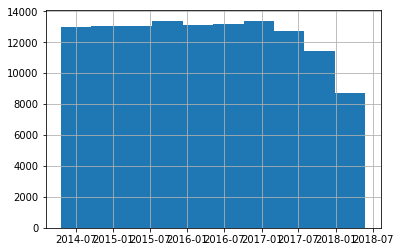

In [35]:
df.date.hist()

## Category Distribution

### Number of categories

In [6]:
len(set(df['category'].values))

31

### Category by count

Most of the articles are related to politics. Education related articles have the lowest volume.

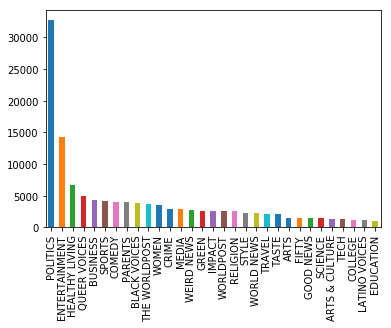

In [7]:
df['category'].value_counts().plot(kind='bar')

## Texts for Classification

These are some of the fields we can use for the classification task. We create 3 different versions.

In [8]:
import re

def tokenize_url(url:str):   
    url=url.replace("https://www.huffingtonpost.com/entry/","")
    url=re.sub("(\W|_)+"," ",url)
    return url

df['tokenized_url']=df['link'].apply(lambda x:tokenize_url(x))

#just the description
df['text_desc'] = df['short_description']

#description + headline
df['text_desc_headline'] = df['short_description'] + ' '+ df['headline']

#description + headline + tokenized url
df['text_desc_headline_url'] = df['short_description'] + ' '+ df['headline']+" " + df['tokenized_url']


In [9]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy


In [31]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   
    
def train_model(df,field="text_desc",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 2000,)

    # GET LABELS
    Y_train=training_data['category'].values
    Y_test=testing_data['category'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k


## Train a Single Model

### Model  - 1  (binary features with description only)

In [11]:
field='text_desc'
feature_rep='binary'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-07-24 22:23:59,473 : INFO : Starting model training...
2019-07-24 22:23:59,592 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:24:02,529 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:26:51,160 : INFO : Starting evaluation...
2019-07-24 22:26:51,233 : INFO : Done training and evaluation.



Accuracy=0.5980542754736303; MRR=0.48048941798943345


### Model - 2 (tfidf features with description only)

In [12]:
field='text_desc'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-07-24 22:26:51,270 : INFO : Starting model training...
2019-07-24 22:26:51,339 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:26:54,293 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:27:40,881 : INFO : Starting evaluation...
2019-07-24 22:27:40,959 : INFO : Done training and evaluation.



Accuracy=0.6306323604710702; MRR=0.5108380269670774


### Model - 3 (tfidf features with description, headline, url)

In [32]:
field='text_desc_headline_url'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2019-07-25 10:58:24,229 : INFO : Starting model training...
2019-07-25 10:58:24,337 : INFO : Extracting features and creating vocabulary...
2019-07-25 10:58:30,587 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-25 10:59:30,760 : INFO : Starting evaluation...
2019-07-25 10:59:30,827 : INFO : Done training and evaluation.



Accuracy=0.8672555043522785; MRR=0.7511520737327071


## Check Predictions on Unseen Articles from CNN (not HuffPost our training data)

In [14]:
# https://www.cnn.com/2019/07/19/politics/george-nader-child-porn-sex-charges/index.html
test_features=transformer.transform(["George Aref Nader, who was a key witness in special counsel Robert Mueller's Russia investigation, faces new charges of transporting a minor with intent to engage in criminal sexual activity and child pornography"])
get_top_k_predictions(model,test_features,2)

[['POLITICS', 'CRIME']]

In [15]:
# https://www.cnn.com/2019/07/18/entertainment/khloe-kardashian-true-thompson-video-trnd/index.html
test_features=transformer.transform(["True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video"])
model.predict(test_features)
get_top_k_predictions(model,test_features,2)

[['ENTERTAINMENT', 'STYLE']]

In [16]:
# https://www.cnn.com/2019/07/12/entertainment/heidi-klum-tom-kaulitz/
test_features=transformer.transform(["Heidi Klum is apparently the latest celeb to get married and not tell us"])
get_top_k_predictions(model,test_features,2)

[['ENTERTAINMENT', 'STYLE']]

In [17]:
# https://www.cnn.com/2019/07/19/investing/dow-stock-market-today/index.html
test_features=transformer.transform(["Stocks end lower as geopolitical fears rise. The Dow and US markets closed lower on Friday, as geopolitical worries overshadowed the hopes of interest rate cuts by the Federal Reserve."])
get_top_k_predictions(model,test_features,2)

[['BUSINESS', 'POLITICS']]

In [18]:
# https://www.cnn.com/2019/07/19/health/astronaut-exercise-iv-faint-scn/index.html
test_features=transformer.transform(["Exercise in space keeps astronauts from fainting when they return to Earth, study says. "])
get_top_k_predictions(model,test_features,2)

[['SCIENCE', 'HEALTHY LIVING']]

## Train Different Types of Models

In [19]:
feature_reps=['binary','counts','tfidf']
fields=['text_desc','text_desc_headline','text_desc_headline_url']
top_ks=[3]

results=[]
for field in fields:
    for feature_rep in feature_reps:
        for top_k in top_ks:
            model,transformer,acc,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
            results.append([field,feature_rep,top_k,acc,mrr_at_k])

2019-07-24 22:28:47,651 : INFO : Starting model training...
2019-07-24 22:28:47,723 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:28:50,558 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:31:28,308 : INFO : Starting evaluation...
2019-07-24 22:31:28,379 : INFO : Done training and evaluation.
2019-07-24 22:31:28,420 : INFO : Starting model training...
2019-07-24 22:31:28,481 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:31:31,446 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:35:19,750 : INFO : Starting evaluation...
2019-07-24 22:35:19,806 : INFO : Done training and evaluation.
2019-07-24 22:35:19,841 : INFO : Starting model training...
2019-07-24 22:35:19,893 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:35:22,875 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:36:02,539 : INFO : Starting evaluation...
2019-07-24 22:36:02,595 : INFO : Done training and evaluation.
2019-07-24 22:36:02,624 : INFO : Starting model training...
2019-07-24 22:36:02,673 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:36:06,786 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:39:03,363 : INFO : Starting evaluation...
2019-07-24 22:39:03,431 : INFO : Done training and evaluation.
2019-07-24 22:39:03,475 : INFO : Starting model training...
2019-07-24 22:39:03,537 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:39:08,216 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:43:19,051 : INFO : Starting evaluation...
2019-07-24 22:43:19,121 : INFO : Done training and evaluation.
2019-07-24 22:43:19,177 : INFO : Starting model training...
2019-07-24 22:43:19,226 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:43:23,554 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:44:10,181 : INFO : Starting evaluation...
2019-07-24 22:44:10,246 : INFO : Done training and evaluation.
2019-07-24 22:44:10,283 : INFO : Starting model training...
2019-07-24 22:44:10,347 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:44:16,205 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:47:02,841 : INFO : Starting evaluation...
2019-07-24 22:47:02,911 : INFO : Done training and evaluation.
2019-07-24 22:47:02,954 : INFO : Starting model training...
2019-07-24 22:47:03,015 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:47:08,877 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:51:38,879 : INFO : Starting evaluation...
2019-07-24 22:51:38,942 : INFO : Done training and evaluation.
2019-07-24 22:51:38,996 : INFO : Starting model training...
2019-07-24 22:51:39,047 : INFO : Extracting features and creating vocabulary...
2019-07-24 22:51:45,424 : INFO : Training a Logistic Regression Model...


[LibLinear]

2019-07-24 22:52:40,328 : INFO : Starting evaluation...
2019-07-24 22:52:40,407 : INFO : Done training and evaluation.


### Results of Various Models

In [20]:
df_results=pd.DataFrame(results,columns=['text_fields','feature_representation','top_k','accuracy','mrr_at_k'])
df_results.sort_values(by=['text_fields','accuracy'],ascending=False)

,text_fields,feature_representation,top_k,accuracy,mrr_at_k
8,text_desc_headline_url,tfidf,3,0.867256,0.751152
6,text_desc_headline_url,binary,3,0.830165,0.715587
7,text_desc_headline_url,counts,3,0.829653,0.718131
5,text_desc_headline,tfidf,3,0.835925,0.717171
3,text_desc_headline,binary,3,0.794675,0.679169
4,text_desc_headline,counts,3,0.792179,0.677894
2,text_desc,tfidf,3,0.630632,0.510838
0,text_desc,binary,3,0.598054,0.480489
1,text_desc,counts,3,0.595526,0.478436
